# EN.605.646.81: Natural Language Processing, Fall 2024
## Applied and Computational Mathematics
## Johns Hopkins University
## Andres Davila Corujo

### Lab 2: Language Models

(a) Study the training data

In [135]:
# read all documents and create vocabulary
import pandas as pd
train = None
train = pd.read_csv('./train.tsv', delimiter='\t', header=None, encoding='iso-8859-1')
train.columns = ['stars', 'doc_id', 'text']

import logging
logger = logging.getLogger(__name__)
logging.basicConfig(encoding='utf-8', level=logging.exception)

Let's start by reading the data and creating a vocabulary for both negative and positive reviews. The intent is to have an idea of the language used in both sentiments.

In [136]:
train_features = {}

negative_vocabulary = []
positive_vocabulary = []
# dev['text_mod'] = dev['text'].apply(lambda row_text: strip_stop_words(row_text, stop_words))

for text, stars in train[['text', 'stars']].values:
    text = text.split(' ')
    if stars < 3:
        negative_vocabulary.extend(text)
    if stars > 3:
        positive_vocabulary.extend(text)

positive_vocabulary = list(set(positive_vocabulary))
negative_vocabulary = list(set(negative_vocabulary))

positive_vocabulary.remove('')
negative_vocabulary.remove('')

negative_vocabulary = [neg.replace('\\u00e9', 'é') for neg in negative_vocabulary]
negative_vocabulary = [neg.replace('\\u00e7u', 'çu') for neg in negative_vocabulary]

positive_vocabulary = [neg.replace('\\u00e9', 'é') for neg in positive_vocabulary]
positive_vocabulary = [neg.replace('\\u00e7u', 'çu') for neg in positive_vocabulary]

Text(0.5, 1.0, 'Good reviews word cloud')

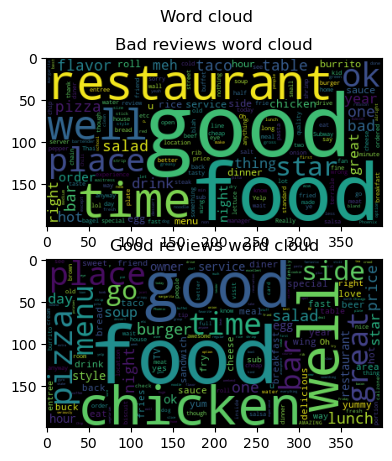

In [137]:
import numpy as np
from wordcloud import WordCloud
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2)
fig.suptitle('Word cloud')

good_wc = WordCloud().generate(" ".join(positive_vocabulary))
bad_wc = WordCloud().generate(" ".join(negative_vocabulary))
ax[0].imshow(bad_wc)
ax[0].set_title('Bad reviews word cloud')
ax[1].imshow(good_wc)
ax[1].set_title('Good reviews word cloud')

Using the plots above we can see negative and positive reviews share the same words often, mostly about foods. This doesn't surprise me given some reviewers might be complaining or complementing the food and or place. Given these words, I'm curious to know how often they appear in each dataset. Is one word dwarfed when compared to the other sentiment? Let's grab the first 5 words of each sentiment and plot their frequency in the reviews.

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),
 [Text(0, 0, 'good'),
  Text(1, 0, 'food'),
  Text(2, 0, 'place'),
  Text(3, 0, 'time'),
  Text(4, 0, 'great'),
  Text(5, 0, 'chicken'),
  Text(6, 0, 'menu'),
  Text(7, 0, 'well'),
  Text(8, 0, 'bar'),
  Text(9, 0, 'pizza'),
  Text(10, 0, 'one'),
  Text(11, 0, 'ok'),
  Text(12, 0, 'restaurant'),
  Text(13, 0, 'star')])

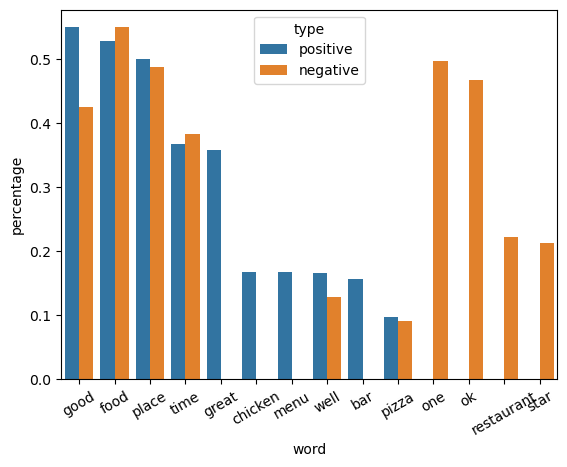

In [138]:
import seaborn as sns

top_n = 10
good_words = list(good_wc.words_)[:top_n]
bad_words = list(bad_wc.words_)[:top_n]
negative_dev = train[train['stars'] < 3]
positive_dev = train[train['stars'] > 3]
negative_word_count = {
    word: {'count': 0, 'percentage': 0, 'type': 'negative'}
    for word in bad_words
}
positive_word_count = {
    word: {'count': 0, 'percentage': 0, 'type': 'positive'}
    for word in good_words
}

for i, row in negative_dev.iterrows():
    for word, value in negative_word_count.items():
        if word in row['text']:
            negative_word_count[word]['count'] += 1
            negative_word_count[word]['percentage'] = negative_word_count[word]['count'] / negative_dev.shape[0]

for i, row in positive_dev.iterrows():
    for word, _ in positive_word_count.items():
        if word in row['text']:
            positive_word_count[word]['count'] += 1
            positive_word_count[word]['percentage'] = positive_word_count[word]['count'] / positive_dev.shape[0]

positive_df = pd.DataFrame(positive_word_count).T
positive_df['word'] = positive_df.index
positive_df = positive_df.sort_values(by=['count'], ascending=False)
negative_df = pd.DataFrame(negative_word_count).T
negative_df['word'] = negative_df.index
negative_df = negative_df.sort_values(by=['count'], ascending=False)


# get the difference between the two sentiments
reviews = pd.concat([positive_df,negative_df]).drop_duplicates(keep=False)

sns.barplot(data=reviews, x='word', y='percentage', hue='type')
plt.xticks(rotation=30)

The plot describes the frequency each word has in each sentiment. There isn't a big spread between each sentiment for each word...I think this could make our classification task a bit harder. Outside of the shared words we see a couple that do not appear in the opposite sentiment, particularly for the positive sentiment. Given some are shared, some are not, this could be a useful feature for our classifier. Let's capture this and add this to our feature list.

Good reviews average length in characters: 6.273561661839061
Bad reviews average length in characters: 6.3716860543569895


/opt/homebrew/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


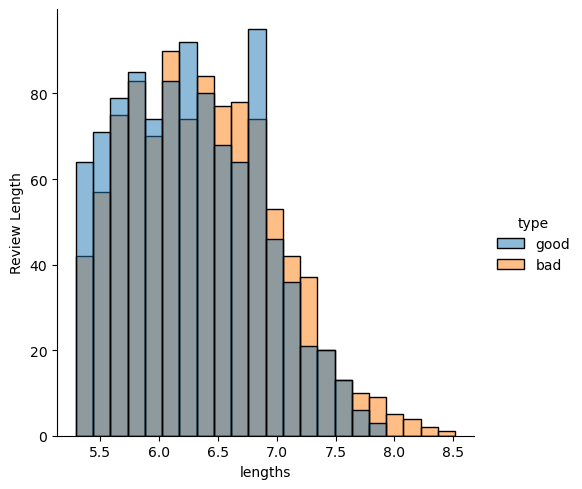

In [140]:
# how long is each review?
import math
train['review_length'] = train['text'].apply(lambda x: math.log(len(x)))

review_lengths = {
    'lengths': [],
    'type': []
}


avg_review_length_bad = train['review_length'][train['stars'] < 3]
avg_review_length_good = train['review_length'][train['stars'] > 3]

review_lengths['lengths'].extend(avg_review_length_good.values)
review_lengths['type'].extend(['good']*avg_review_length_good.shape[0])

review_lengths['lengths'].extend(avg_review_length_bad.values)
review_lengths['type'].extend(['bad']*avg_review_length_bad.shape[0])

sns.displot(review_lengths, x="lengths", hue='type')
plt.ylabel('Review Length')

print('Good reviews average length in characters:', avg_review_length_good.mean())
print('Bad reviews average length in characters:', avg_review_length_bad.mean())

The plot above shows a distribution for the reviews lengths by type of review, good (positive) and bad (negative). I capture this length in log space given we are counting the length in characters, and this could be fairly large (500+). When compared to other features, like a specific word count, this will greatly skew the model.

The plot itself describes our training data which doesn't show a big spread between both sentiments. What we can see is that positive reviews tend to be longer in character than negative reviews. Intuitively this baffles me given I always tend to associate bad reviews with very lengthy ones. 

Good reviews average word count: 2.771841362398701
Bad reviews average word count: 2.8464844387852457


/opt/homebrew/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


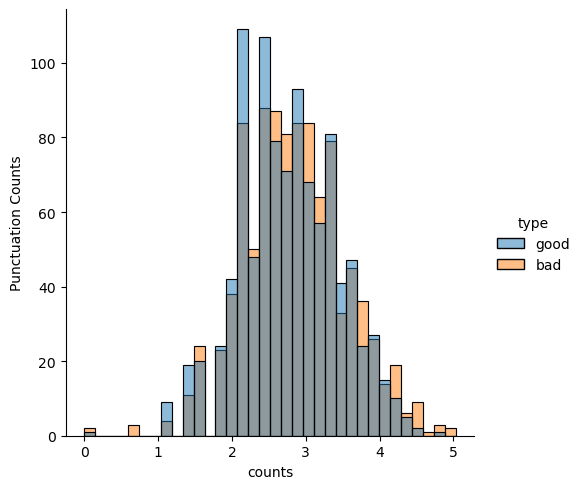

In [142]:
# how much punctuation marks does each sentiment have?
from nltk import word_tokenize
from collections import Counter

def count_punc(text):
    tokens = word_tokenize(text)
    punct_counts = Counter(token for token in tokens if not token.isalnum())
    sum_values = sum(punct_counts.values())
    return math.log(sum_values) if sum_values != 0 else 0

train['punc_count'] = train['text'].apply(lambda t: count_punc(t))

review_punc_counts = {
    'counts': [],
    'type': []
}

avg_review_punc_count_good = train['punc_count'][train['stars'] > 3]
avg_review_punc_count_bad = train['punc_count'][train['stars'] < 3]

review_punc_counts['counts'].extend(avg_review_punc_count_good.values)
review_punc_counts['type'].extend(['good']*avg_review_punc_count_good.shape[0])

review_punc_counts['counts'].extend(avg_review_punc_count_bad.values)
review_punc_counts['type'].extend(['bad']*avg_review_punc_count_bad.shape[0])

sns.displot(review_punc_counts, x="counts", hue='type')
plt.ylabel('Punctuation Counts')

print('Good reviews average word count:', avg_review_punc_count_good.mean())
print('Bad reviews average word count:', avg_review_punc_count_bad.mean())

Given our previous plot of review lengths in character I expect good (positive) reviews to have more punctuation marks than bad (negative) reviews. The plot describes the distribution of punctuation counts in the corpus for both good (positive) and bad (negative) reviews. As with other plots, the spread is not too big. Regardless we can see bad reviews tend to have more reviews with fewer punctuation counts. We can see this by the upper tail of the distribution. 

Good reviews average positive word count: 7.992962181862513
Bad reviews average positive word count: 5.834785387800443


/opt/homebrew/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


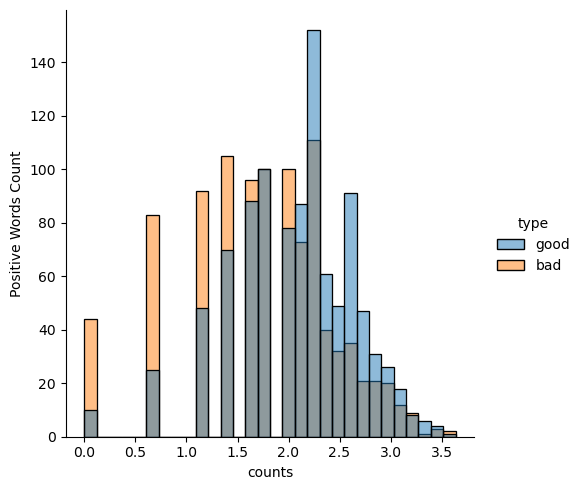

In [143]:
"""
Now other common words seen in good reviews are love, lovely, helpful, happy, knowledgeable, excellent. 
Even though some these words didn't appear in the word cloud, let's see how often they appear in the data. 
Let's use a sample lexicon to build this feature.
https://ptrckprry.com/course/ssd/data/positive-words.txt
"""
good_lexicon = pd.read_csv('https://ptrckprry.com/course/ssd/data/positive-words.txt', skiprows=33)
good_lexicon = good_lexicon.values.flatten()

def count_positive_words(text: str):
    count = 0
    for word in good_lexicon:
        if word.lower() in text.lower():
            count += 1
    if count == 0: return 0
    return math.log(count)

train['positive_word_count'] = train['text'].apply(lambda x: count_positive_words(x))

review_punc_counts = {
    'counts': [],
    'type': []
}

avg_review_punc_count_good = train['positive_word_count'][train['stars'] > 3]
avg_review_punc_count_bad = train['positive_word_count'][train['stars'] < 3]

review_punc_counts['counts'].extend(avg_review_punc_count_good.values)
review_punc_counts['type'].extend(['good']*avg_review_punc_count_good.shape[0])

review_punc_counts['counts'].extend(avg_review_punc_count_bad.values)
review_punc_counts['type'].extend(['bad']*avg_review_punc_count_bad.shape[0])

sns.displot(review_punc_counts, x="counts", hue='type')
plt.ylabel('Positive Words Count')

print('Good reviews average positive word count:', math.exp(avg_review_punc_count_good.mean()))
print('Bad reviews average positive word count:', math.exp(avg_review_punc_count_bad.mean()))

This plot is pretty accurate. It plots the distribution of positive word counts per sentiment. We can see bad (negative) reviews tend to be more frequent the lower half while good (positive) reviews tend to be more frequent in the upper half of the distribution. This is a good feature to add!

Good reviews average negative word count: 5.072338346611456
Bad reviews average negative word count: 7.096554261533744


/opt/homebrew/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


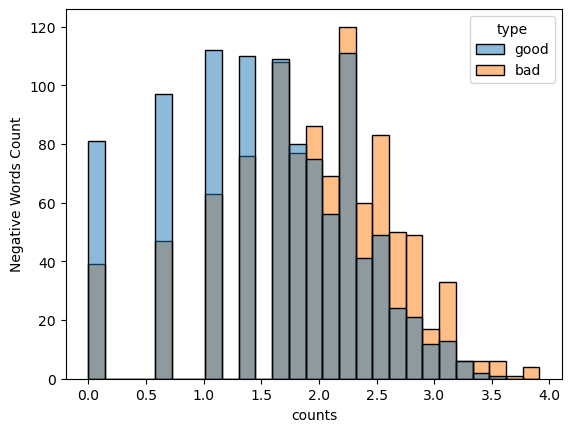

In [144]:
# let's see how the data plots for a negative lexicon
bad_lexicon = pd.read_csv('https://ptrckprry.com/course/ssd/data/negative-words.txt', skiprows=33, encoding='latin-1')
bad_lexicon = bad_lexicon.values.flatten()

def count_negative_words(text: str):
    count = 0
    for word in bad_lexicon:
        if word.lower() in text.lower():
            count += 1
    if count == 0: return 0
    return math.log(count)

train['negative_word_count'] = train['text'].apply(lambda x: count_negative_words(x))

review_punc_counts = {
    'counts': [],
    'type': [],
}

avg_review_punc_count_good = train['negative_word_count'][train['stars'] > 3]
avg_review_punc_count_bad = train['negative_word_count'][train['stars'] < 3]

review_punc_counts['counts'].extend(avg_review_punc_count_good.values)
review_punc_counts['type'].extend(['good']*avg_review_punc_count_good.shape[0])

review_punc_counts['counts'].extend(avg_review_punc_count_bad.values)
review_punc_counts['type'].extend(['bad']*avg_review_punc_count_bad.shape[0])

sns.histplot(review_punc_counts, x='counts', hue='type')
plt.ylabel('Negative Words Count')

print('Good reviews average negative word count:', math.exp(avg_review_punc_count_good.mean()))
print('Bad reviews average negative word count:', math.exp(avg_review_punc_count_bad.mean()))

As expected the distribution is the opposite of the previous plot, having a higher frequency for the bad (negative) sentiment. Let's add this feature to our feature list as well.

The book presented other useful features. Let's plot then one by one to understand them in our corpus.

Good reviews average no's count: 1.6122293186210424
Bad reviews average no's count: 2.177586400784324


/opt/homebrew/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


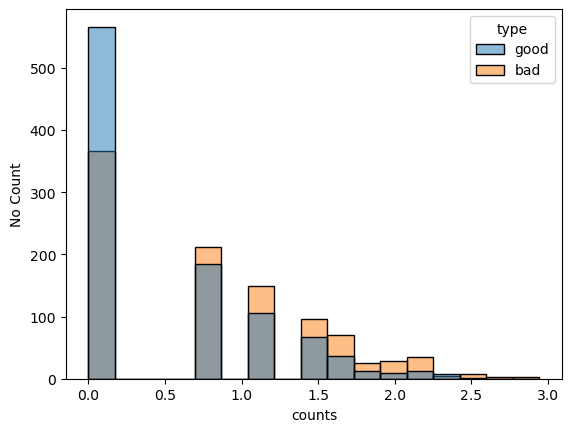

In [145]:
# is 'no' present in the text
def count_no_in_text(text: str):
    count = 0
    for word in text.split(' '):
        if 'no' in word.lower():
            count += 1
    return math.log(count) if count != 0 else 0

train['no_count'] = train['text'].apply(lambda x: count_no_in_text(x))

no_count = {
    'counts': [],
    'type': [],
}

avg_review_punc_count_good = train['no_count'][train['stars'] > 3]
avg_review_punc_count_bad = train['no_count'][train['stars'] < 3]

no_count['counts'].extend(avg_review_punc_count_good.values)
no_count['type'].extend(['good']*avg_review_punc_count_good.shape[0])

no_count['counts'].extend(avg_review_punc_count_bad.values)
no_count['type'].extend(['bad']*avg_review_punc_count_bad.shape[0])

sns.histplot(no_count, x='counts', hue='type')
plt.ylabel('No Count')

print('Good reviews average no\'s count:', math.exp(avg_review_punc_count_good.mean()))
print('Bad reviews average no\'s count:', math.exp(avg_review_punc_count_bad.mean()))

The plot above plots the distribution for the word 'no' for each document. As expected, the negative sentiment (bad) is seen having a higher frequency than its counterpart. Let's add this to our feature list.

Good reviews average pronount's count: 4.08911535000654
Bad reviews average pronount's count: 4.6162986764050915


/opt/homebrew/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


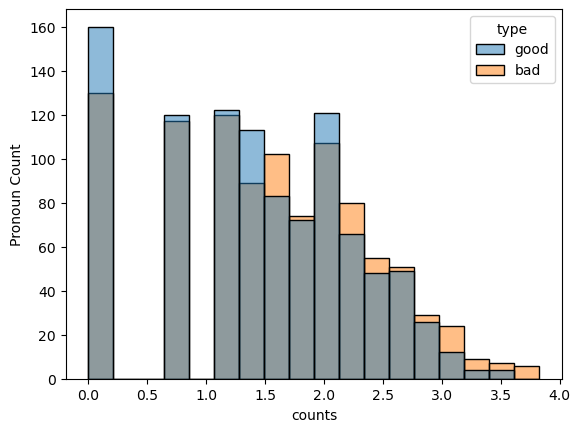

In [154]:
# number of first pronouns in text
pronouns = [
  'i',
  'you',
  'my',
  'mine',
  'myself'
  'we',
  'us',
  'our',
  'ours',
  'ourselves'
  'you',
  'you',
  'your',
  'yours',
  'yourself'
  'you',
  'you',
  'your',
  'your',
  'yourselves'
]
def count_pronouns_in_text(text: str):
    count = 0
    for word in text.split(' '):
        if word.lower() in pronouns:
            count += 1
    return math.log(count) if count != 0 else 0

train['pronoun_count'] = train['text'].apply(lambda x: count_pronouns_in_text(x))

pronoun_count = {
    'counts': [],
    'type': [],
}

avg_review_punc_count_good = train['pronoun_count'][train['stars'] > 3]
avg_review_punc_count_bad = train['pronoun_count'][train['stars'] < 3]

pronoun_count['counts'].extend(avg_review_punc_count_good.values)
pronoun_count['type'].extend(['good']*avg_review_punc_count_good.shape[0])

pronoun_count['counts'].extend(avg_review_punc_count_bad.values)
pronoun_count['type'].extend(['bad']*avg_review_punc_count_bad.shape[0])

sns.histplot(pronoun_count, x='counts', hue='type')
plt.ylabel('Pronoun Count')
print('Good reviews average pronount\'s count:', math.exp(avg_review_punc_count_good.mean()))
print('Bad reviews average pronount\'s count:', math.exp(avg_review_punc_count_bad.mean()))

This plot is interesting, it plots the distribution of 1st and 2nd pronouns in each document. We can see the negative sentiment has a higher tendency to have 1st and 2nd pronouns in its corpus. This can make sense intuitively given people would speak more about their personal experience if it was a negative one than if it would've been a positive one, in my opinion. We can see there is a spread between each sentiment, let's add this to our feature list.

Good reviews average word count: 96.84775816852256
Bad reviews average word count: 108.40389861834848


/opt/homebrew/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


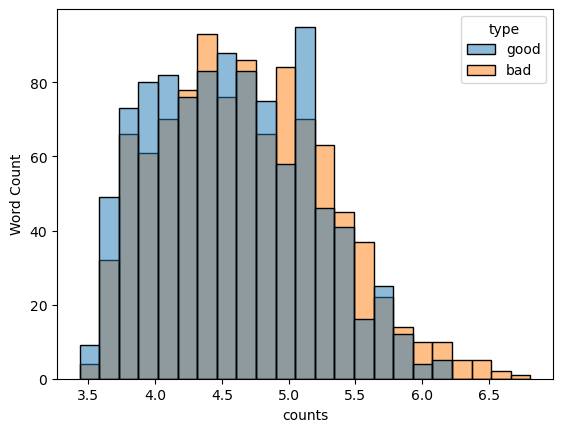

In [155]:
# log count of words
import math
def log_count_words(text: str):
    if math.log(len([word for word in word_tokenize(text) if word.isalnum()])) < 1:
        print(text)
    return math.log(len([word for word in word_tokenize(text) if word.isalnum()]))

train['word_count'] = train['text'].apply(lambda x: log_count_words(x))

token_count = {
    'counts': [],
    'type': [],
}

avg_review_punc_count_good = train['word_count'][train['stars'] > 3]
avg_review_punc_count_bad = train['word_count'][train['stars'] < 3]

token_count['counts'].extend(avg_review_punc_count_good.values)
token_count['type'].extend(['good']*avg_review_punc_count_good.shape[0])

token_count['counts'].extend(avg_review_punc_count_bad.values)
token_count['type'].extend(['bad']*avg_review_punc_count_bad.shape[0])

sns.histplot(token_count, x='counts', hue='type')
plt.ylabel('Word Count')
print('Good reviews average word count:', math.exp(avg_review_punc_count_good.mean()))
print('Bad reviews average word count:', math.exp(avg_review_punc_count_bad.mean()))

The plot above describes the frequency distribution in log space of the count of alphanumeric tokens in each document. I took the log for each document given this number could be fairly big compared to our other features. The plot itself shows that negative reviews tend to have more tokens than its counterpart. 

One of our earlier features describes the character length of each review, showing the positive sentiment having a higher frequency for it. Given this plot, I assume positive reviews tend to have more punctuation marks, smiley faces, and overall more non-alphanumeric characters.

Good reviews average hashtag count: 1.0140984589384923
Bad reviews average hashtag count: 1.0080320855042735


/opt/homebrew/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


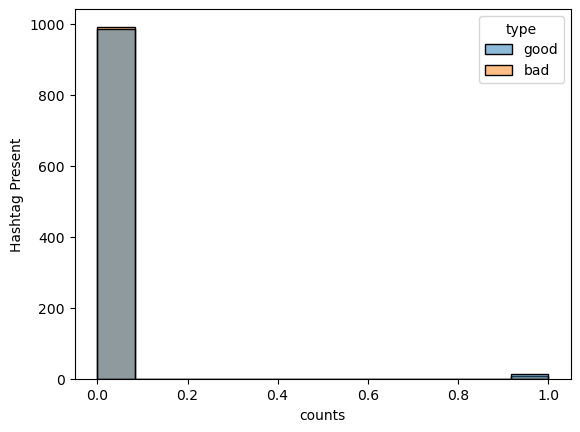

In [156]:
# count hashtags in reviews
def count_hashtags(text: str):
    if '#' in text:
        return 1
    return 0

train['hashtag_present'] = train['text'].apply(lambda x: count_hashtags(x))

hashtag_count = {
    'counts': [],
    'type': [],
}

avg_review_punc_count_good = train['hashtag_present'][train['stars'] > 3]
avg_review_punc_count_bad = train['hashtag_present'][train['stars'] < 3]

hashtag_count['counts'].extend(avg_review_punc_count_good.values)
hashtag_count['type'].extend(['good']*avg_review_punc_count_good.shape[0])

hashtag_count['counts'].extend(avg_review_punc_count_bad.values)
hashtag_count['type'].extend(['bad']*avg_review_punc_count_bad.shape[0])

sns.histplot(hashtag_count, x='counts', hue='type')
plt.ylabel('Hashtag Present')
print('Good reviews average hashtag count:', math.exp(avg_review_punc_count_good.mean()))
print('Bad reviews average hashtag count:', math.exp(avg_review_punc_count_bad.mean()))

Hmm this isn't that useful of a feature. The spread between these two sentiments is very thin. I would've figured positive reviews had more hashtags.

Good reviews average hashtag count: 1.0408107741923882
Bad reviews average hashtag count: 1.0120722888660778


/opt/homebrew/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


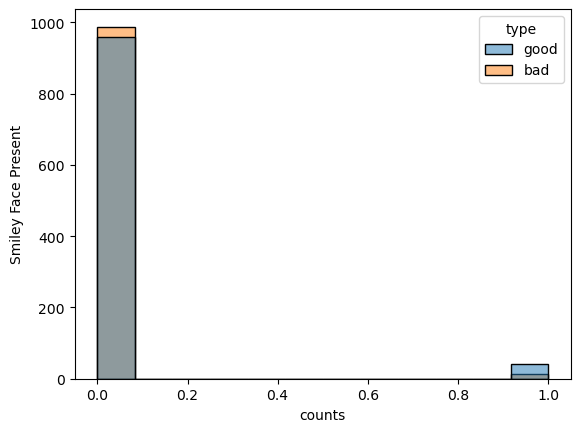

In [158]:
# count smiley faces
def count_smiley_faces(text: str):
    if ':)' in text or ':-)' in text:
        return 1
    return 0

train['smiley_present'] = train['text'].apply(lambda x: count_smiley_faces(x))

smiley_faces_count = {
    'counts': [],
    'type': [],
}

avg_review_punc_count_good = train['smiley_present'][train['stars'] > 3]
avg_review_punc_count_bad = train['smiley_present'][train['stars'] < 3]

smiley_faces_count['counts'].extend(avg_review_punc_count_good.values)
smiley_faces_count['type'].extend(['good']*avg_review_punc_count_good.shape[0])

smiley_faces_count['counts'].extend(avg_review_punc_count_bad.values)
smiley_faces_count['type'].extend(['bad']*avg_review_punc_count_bad.shape[0])

sns.histplot(smiley_faces_count, x='counts', hue='type')
plt.ylabel('Smiley Face Present')
print('Good reviews average hashtag count:', math.exp(avg_review_punc_count_good.mean()))
print('Bad reviews average hashtag count:', math.exp(avg_review_punc_count_bad.mean()))

This feature makes sense. The plot shows the count of smiley faces in the corpus per document. We can see the negative (bad) sentiment has less smiley faces than the positive sentiment. Even though the spread is very thin as well, let's make use of this feature.

### Bag of Words Representation

Build custom BagOfWords representation that adds the features we've explored so far.

### (b) Train a classifier

## Description
The feature representation used for this model expands on a naive bag of words representation. It adds simple features discovered in the notebook's EDA such as punctuation counts, length of review, count of positive words, count of negative words, and a count of the top ten words seen in both negative and positive reviews.

In [172]:
# let's now add our own features
import math
import regex
import nltk
import pandas as pd
from collections import Counter
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
from nltk import word_tokenize

"""
Feature list:
"""
class FeatureEncoder():
    def __init__(self):
        self.positive_words = pd.read_csv('https://ptrckprry.com/course/ssd/data/positive-words.txt', skiprows=33).values.flatten()
        self.negative_words = pd.read_csv('https://ptrckprry.com/course/ssd/data/negative-words.txt', skiprows=33, encoding='latin-1').values.flatten()
        self.words_to_count = ['food', 'place', 'good','one','well','pizza','eat','great','cheese','night','service','star','ok','restaurant',]
        self.pronouns = [
            'i',
            'you',
            'my',
            'mine',
            'myself'
            'we',
            'us',
            'our',
            'ours',
            'ourselves'
            'you',
            'you',
            'your',
            'yours',
            'yourself'
            'you',
            'you',
            'your',
            'your',
            'yourselves'
        ]
        self.stop_words = nltk.corpus.stopwords.words('english')
        self.vocabulary = []
        self.bow=None
        self.features=None

    def fit(self, text: pd.DataFrame):
        """
        Create features
        """
        self.bow = None
        self.bow = self.create_bag_of_words(text)

    def transform(self, text: pd.DataFrame):
        features = pd.DataFrame()
        
        # count smiley
        logging.debug('[*] creating smiley_count')
        features['smiley_count'] = text['text'].apply(self.count_smiley_faces)
        # count hastags
        logging.debug('[*] creating hashtag_count')
        features['hastag_count'] = text['text'].apply(self.count_hashtags)
        # word count
        logging.debug('[*] creating word_count')
        features['word_count'] = text['text'].apply(self.log_count_words)
        #pronoun count
        logging.debug('[*] creating pronoun_count')
        features['pronoun_count'] = text['text'].apply(self.count_pronouns_in_text)
        #no in text count
        logging.debug('[*] creating no_count')
        features['no_count'] = text['text'].apply(self.count_no_in_text)
        # common word count
        logging.debug('[*] creating common_words_count')
        features['common_words_count'] = text['text'].apply(self.common_word_count)
        # punc count
        logging.debug('[*] creating punc_count')
        features['punc_count'] = text['text'].apply(self.count_punc)
        # positive word count
        logging.debug('[*] creating positive_word_count')
        features['positive_count'] = text['text'].apply(self.count_positive_words)
        # negative word count
        logging.debug('[*] creating negative_word_count')
        features['negative_count'] = text['text'].apply(self.count_negative_words)
        # double !! count
        logging.debug('[*] creating double_exclamation_count')
        features['double_exclamation_count'] = text['text'].apply(self.double_punctuation_count)
        # number list (1)) count
        logging.debug('[*] creating list_count')
        features['list_count'] = text['text'].apply(self.double_punctuation_count)
        # create bag of words
        logging.debug('[*] creating bag of words')
        bag_of_word = self.populate_bag_of_words(text)
    
        columns = ['smiley_count', 'hastag_count', 'word_count', 'pronoun_count', 'no_count','common_words_count',
                   'punc_count','positive_count', 'negative_count','double_exclamation_count','list_count']
        bow_columns = ['bow_f_' + str(i) for i in range(bag_of_word.shape[1])]
        columns.extend(bow_columns)

        features = pd.concat([features, bag_of_word], axis=1)
        features.columns = columns

        return features

    def fit_transform(self, text: pd.DataFrame):
        self.fit(text)
        return self.transform(text)
    
    def count_smiley_faces(self, text: str):
        if ':)' in text or ':-)' in text:
            return 1
        return 0

    def count_hashtags(self, text: str):
        if '#' in text:
            return 1
        return 0

    def log_count_words(self, text: str):
        length = len([word for word in nltk.word_tokenize(text) if word.isalnum()])
        return math.log(length) if length != 0 else 0

    def count_pronouns_in_text(self, text: str):
        count = 0
        for word in nltk.word_tokenize(text):
            count += int(word.lower() in self.pronouns)
        return math.log(count) if count != 0 else 0

    def count_no_in_text(self, text: str):
        count = 0
        for word in nltk.word_tokenize(text):
            count += int('no' == word.lower())
        return math.log(count) if count != 0 else 0

    def common_word_count(self, text: str):
        count = 0
        for word in text:
            count += int(word.lower() in self.words_to_count)
        return math.log(count) if count != 0 else 0


    def count_punc(self,text):
        tokens = nltk.word_tokenize(text)
        punct_counts = Counter(token for token in tokens if not token.isalnum())
        sum_values = sum(punct_counts.values())
        return math.log(sum_values) if sum_values != 0 else 0

    def count_positive_words(self, text: str):
        count = 0
        for word in nltk.word_tokenize(text.lower()):
            count += int(word in self.positive_words)
        return math.log(count) if count != 0 else 0

    def count_negative_words(self, text: str):
        count = 0
        for word in nltk.word_tokenize(text.lower()):
            count += int(word in self.negative_words)
        return math.log(count) if count != 0 else 0

    def double_punctuation_count(self, text:str):
        return int('!!' in text)
    
    def number_list_count(self,text:str):
        """
        Check if review has itemized list, e.g. 1) 2) 3)...
        """
        pattern = regex.compile('/\d\)/gm')
        matched_1 = 1 if regex.search(pattern, text) is not None else 0
        pattern = regex.compile('/\d\./gm')
        matched_2 = 1 if regex.search(pattern, text) is not None else 0
        return any([matched_1 == 1, matched_2 == 1])

    def build_vocabulary(self, text: pd.DataFrame):
        # remove stop words
        def remove_words(tokens):
            return [t for t in tokens if t not in self.stop_words]
        # temp words
        # def stem_words(tokens):
            # return [self.stemmer.stem(t) for t in tokens]

        vocabulary = []
        for t in text['text']:
            tokens = nltk.word_tokenize(t)
            tokens = remove_words(tokens)
            # tokens = stem_words(tokens)
            vocabulary.extend(tokens)
        return list(set(vocabulary))

    def create_bag_of_words(self, text: pd.DataFrame):
        self.vocabulary = self.build_vocabulary(text)
        bow = []
        for i, row in text.iterrows():
            bag = [0]*len(self.vocabulary)
            t = row['text']
            for i,v in enumerate(self.vocabulary):
                if v in t:
                    bag[i] += 1
            bow.append(bag)
        return pd.DataFrame(bow)

    def populate_bag_of_words(self, text: pd.DataFrame):
        """Use existing vocabulary to fill bow"""
        bow = []
        for i, row in text.iterrows():
            bag = [0]*len(self.vocabulary)
            t = row['text']
            for i,v in enumerate(self.vocabulary):
                if v in t:
                    bag[i] += 1
            bow.append(bag)
        return pd.DataFrame(bow)



In [173]:
# encode features and run model
ft = FeatureEncoder()

In [174]:
train = pd.read_csv('./train.tsv', delimiter='\t', header=None, encoding='iso-8859-1')
train.columns = ['stars', 'doc_id', 'text']

dev = pd.read_csv('./dev.tsv', delimiter='\t', header=None, encoding='iso-8859-1')
dev.columns = ['stars', 'doc_id', 'text']


ft.fit(train)
train_x = ft.transform(train)
train_y = train['stars'].values

dev_train_x = ft.transform(dev).values
dev_train_y = dev['stars'].values

DEBUG:root:[*] creating smiley_count
DEBUG:root:[*] creating hashtag_count
DEBUG:root:[*] creating word_count
DEBUG:root:[*] creating pronoun_count
DEBUG:root:[*] creating no_count
DEBUG:root:[*] creating common_words_count
DEBUG:root:[*] creating punc_count
DEBUG:root:[*] creating positive_word_count
DEBUG:root:[*] creating negative_word_count
DEBUG:root:[*] creating double_exclamation_count
DEBUG:root:[*] creating list_count
DEBUG:root:[*] creating bag of words
DEBUG:root:[*] creating smiley_count
DEBUG:root:[*] creating hashtag_count
DEBUG:root:[*] creating word_count
DEBUG:root:[*] creating pronoun_count
DEBUG:root:[*] creating no_count
DEBUG:root:[*] creating common_words_count
DEBUG:root:[*] creating punc_count
DEBUG:root:[*] creating positive_word_count
DEBUG:root:[*] creating negative_word_count
DEBUG:root:[*] creating double_exclamation_count
DEBUG:root:[*] creating list_count
DEBUG:root:[*] creating bag of words


Training data has 14817 features


<Axes: xlabel='pc1', ylabel='pc2'>

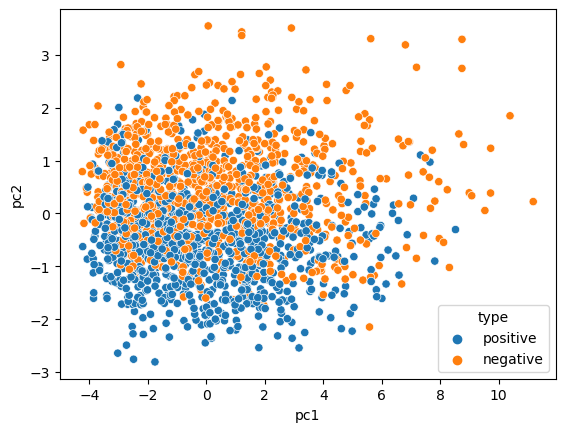

In [175]:
from sklearn.decomposition import PCA
import seaborn as sns

print(f'Training data has {train_x.shape[1]} features')

pca = PCA(n_components=2)
components = pca.fit_transform(train_x) 
pca_view = {
    'pc1': components[:, 0],
    'pc2': components[:, 1],
    'type': ['positive' if y == 4 else 'negative' for y in train_y]
}
sns.scatterplot(data=pca_view, x='pc1',y='pc2',hue='type')

The plot above depicts the features I built reduced to 2 dimensions for visualization purposes. Even though this plot should be taken with a grain of salt given we are reducing a matrix of dim(matrix)=100, approximately, down to 2, it gives us an idea of how the features could be separated in their higher dimensional space.

The plot shows how both sentiments can be somewhat separated. This can be interpreted as a good indication of our features. Ideally I want our features to be somewhat linearly separable. The more they are, the better a classifier I could train, presumably. Let's checkout how the matrix looks.

In [176]:
train_x.head(2)

,smiley_count,hastag_count,word_count,pronoun_count,no_count,common_words_count,punc_count,positive_count,negative_count,double_exclamation_count,...,bow_f_14796,bow_f_14797,bow_f_14798,bow_f_14799,bow_f_14800,bow_f_14801,bow_f_14802,bow_f_14803,bow_f_14804,bow_f_14805
0,0,0,5.181784,2.197225,0.0,0,3.044522,1.098612,0.000000,1,...,0,0,0,0,0,0,0,0,0,0
1,0,0,4.477337,1.098612,0.0,0,2.772589,2.079442,2.079442,0,...,0,0,0,0,0,0,0,0,0,0


Let's plot this out, it might be easier on the eyes.
NOTE: The matrix has a very high dimension. I'm only going to plot the first columns germane to our custom features given the rest belong to the bag-of-words representation.

Text(0.5, 1.0, 'Features for record 315 of sentiment POSITIVE')

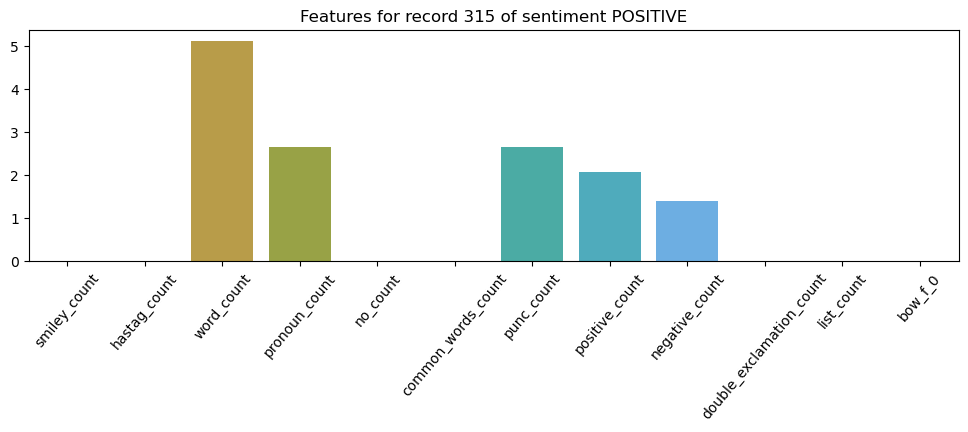

In [222]:
import numpy as np
RECORD=np.random.randint(low=0, high=train_x.shape[0])
# find first bag of word feature to slice by
bog_slice=list(train_x.columns).index('bow_f_1')
features={
    'features': train_x.iloc[RECORD, :bog_slice].keys(),
    'values': train_x.iloc[RECORD, :bog_slice].values
}
plt.figure(figsize=(12, 3))
sns.barplot(data=features, x='features', y='values')
plt.xticks(rotation=50)
plt.title(f'Features for record {RECORD} of sentiment {"POSITIVE" if train_y[RECORD] == 4 else "NEGATIVE"}')

The plot depicts how each feature is represented for the given record. We can see it has a high count for words, pronouns, and punctuations. It also has both words from the negative and positive lexicon oddly enough. Let's run this though the classifier and see it's prediciton.

In [223]:
# first classifier
from sklearn.svm import SVC

svm = SVC()
svm.fit(train_x, train_y)

dev_pred_y = svm.predict(dev_train_x)

/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


(c) Evaluate your predictions

In [224]:
def calculate_confusion_matrix(y_true, y_pred, positive=4):
    true_positives = []
    false_positives = []
    true_negative = []
    false_negative = []
    for i, (pred, true) in enumerate(zip(y_true, y_pred)):
        if pred == positive and pred == true:
            true_positives.append(i)
        if pred == positive and pred != true:
            false_positives.append(i)
        if pred != positive and pred == true:
            true_negative.append(i)
        if pred != positive and pred != true:
            false_negative.append(i)
    return true_positives, false_positives, true_negative, false_negative   

def precision(true_positives, false_positives):
    return len(true_positives) / (len(true_positives) + len(false_positives))

def recall(true_positives, false_negatives):
    return len(true_positives) / (len(true_positives) + len(false_negatives))

def f1_score_local(precision, recall, beta=1):
    return (beta**2 + 1)*precision*recall / ((beta**2)*precision + recall)

true_positives, false_positives, true_negatives, false_negatives = calculate_confusion_matrix(dev_train_y, dev_pred_y)


precision_score = precision(true_positives, false_positives)
recall_score = recall(true_positives, false_negatives)
f1_score = f1_score_local(precision_score, recall_score)
print('Recall:', recall_score)
print('Precision:', precision_score)
print('F1 Score:', f1_score)

Recall: 0.8431372549019608
Precision: 0.817
F1 Score: 0.8298628745556119


In [228]:
# explore record shown in the feature representation plot
dev_pred_y[315]

4

We saw in the plot the record was of the positive sentiment. The output above shows our classifier predicted the record correctly.

Okay the classifier is not performing bad. Let's explore a few mislabeled items.

Doc ID: dhmeDsQGUS1FXMLs49SWjQ
Labeled as: positive
Predicted as: negative
Text: This place is rather eclectic for the area it's in (Far West Madison; Middleton?) and really seems out of place. But, that aside their food is quite excellent and the the wait staff are friendly! It's mostly hybrid Mediterranean (Tunisian?) dishes and there are several vegetarian options! Bonus on that. Overall, I'd go back and didn't give it a 5 because the prices are a bit outrageous. C'mon, fellas! We're not in the Upper East Side... 

Doc ID: HqtEtHHDgSM0ctJHehaWaw
Labeled as: negative
Predicted as: positive
Text: I've never been a big fan of BK, I have held pretty true to my Micky Ds however the chicken fries with multiple dipping sauce options are a great snack.  They are always advertising apple fries for the kids but this location never seems to have any in stock. 

Doc ID: gjWVccNw6kB2UycZAEzyQg
Labeled as: positive
Predicted as: negative
Text: I hate to find out that there was another location cl

/opt/homebrew/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


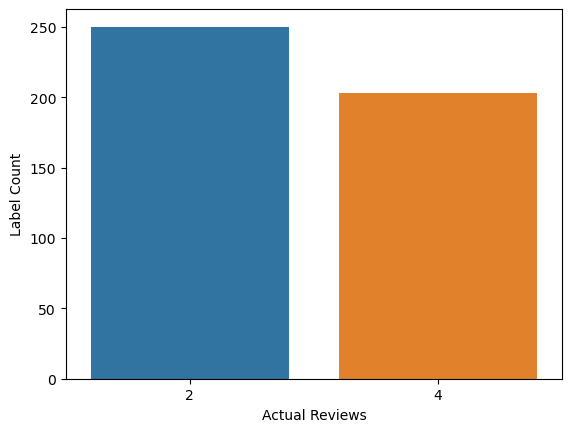

In [24]:
import matplotlib.pyplot as plt
dev['pred'] = dev_pred_y
mislabeled = dev[dev['stars'] != dev['pred']]
mislabeled_count = mislabeled[['stars']].groupby('stars').value_counts()
mislabeled_dict = {
    'review': [],
    'count': []
}
for k, v in mislabeled_count.items():
    mislabeled_dict['review'].append(k)
    mislabeled_dict['count'].append(v)

sns.barplot(data=mislabeled_dict, x='review', y='count')
plt.xlabel('Actual Reviews')
plt.ylabel('Label Count')
for text, label, pred, doc_id in mislabeled[['text','stars','pred','doc_id']].values[:10]:
    print('Doc ID:', doc_id)
    print('Labeled as:', 'positive' if label == 4 else 'negative')
    print('Predicted as:', 'positive' if pred == 4 else 'negative')
    print('Text:',text, '\n')

Document dhmeDsQGUS1FXMLs49SWjQ is interesting. Reading the document you can get a negative scent at the beginning yet it speaks highly of the food and their staff. I think this document got labeled as negative due to the number of punctuation marks in it. 

In the book I noticed the authors spoke about using a shallow NN for sentiment analysis. Let's build one here and see if the model can pickup non-linear relationships. 

(d) Build a second classifier

In [227]:
# second classifier
from sklearn.svm import SVC
import keras
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping


model = Sequential()
model.add(Dense(units=36, input_shape=(train_x.shape[1],), activation='tanh'))
model.add(Dense(units=16, activation='tanh'))
model.add(Dense(units=8, activation='tanh'))
model.add(Dense(units=1, activation='sigmoid'))

# Create an EarlyStopping callback
early_loss_stopping = EarlyStopping(
    monitor='loss',  # Metric to monitor (e.g., validation loss)
    patience=3,          # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)
early_accuracy_stopping = EarlyStopping(
    monitor='loss',  # Metric to monitor (e.g., validation loss)
    patience=3,          # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)

# compile model with binary cross entropy as loss and stochastic gradient descent
model.compile(optimizer=keras.optimizers.SGD(learning_rate=.005), metrics=['accuracy'],
              loss="binary_crossentropy")

# encode train_y
local_train_y = np.array([0 if y == 2 else 1 for y in train_y])
history = model.fit(
            train_x, 
            local_train_y,
            batch_size=16,
            epochs=100,
            callbacks=[early_loss_stopping,early_accuracy_stopping]
        )

dev_pred_y = model.predict(dev_train_x)
# decode pred_y
THRESHOLD = 0.5
dev_pred_y = [2 if y <= THRESHOLD else 4 for y in dev_pred_y]
true_positives, false_positives, true_negatives, false_negatives = calculate_confusion_matrix(dev_train_y, dev_pred_y)

precision_score = precision(true_positives, false_positives)
recall_score = recall(true_positives, false_negatives)
f1_score = f1_score_local(precision_score, recall_score)
print('Recall:', recall_score)
print('Precision:', precision_score)
print('F1 Score:', f1_score)

/opt/homebrew/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6248 - loss: 0.6628
Epoch 2/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7741 - loss: 0.5675
Epoch 3/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8208 - loss: 0.4890
Epoch 4/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8595 - loss: 0.4100
Epoch 5/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8634 - loss: 0.3749
Epoch 6/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8846 - loss: 0.3344
Epoch 7/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8926 - loss: 0.2998
Epoch 8/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9112 - loss: 0.2670
Epoch 9/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9231 - loss: 0.2391
Epoch 10/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9231 - loss: 0.2283
Epoch 11/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9456 - loss: 0.1943
Epoch 12/100
125/125 ━━━━━━━━━━━━━━━━━━━━

Wow the model does not improve. This means the encoding used does not a good job of encoding the semantic behind each review. Let's look at the first ten reviews.

Doc ID: Rcbv11hm5AYEwZyqYwAvg
Labeled as: positive
Predicted as: negative
Text: Meeting a friend for lunch, we had a little miscommunication. He went to the wrong one, so I got to see two CFA's for lunch in one day. Like the other, this one was very busy at lunch time. I guess people are thinking that chicken is healthier than the other options in this shopping plaza?  Large seating area, they have a couple of staff wandering around to improve things. The drink lady is a nice touch and she's super friendly. She even refilled the drink I'd brought from the other CFA, though that's probably not the usual deal.  My friend and I took up the table for a good hour and no one troubled us at all! 

Doc ID: dhmeDsQGUS1FXMLs49SWjQ
Labeled as: positive
Predicted as: negative
Text: This place is rather eclectic for the area it's in (Far West Madison; Middleton?) and really seems out of place. But, that aside their food is quite excellent and the the wait staff are friendly! It's mostly hybrid Medi

/opt/homebrew/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


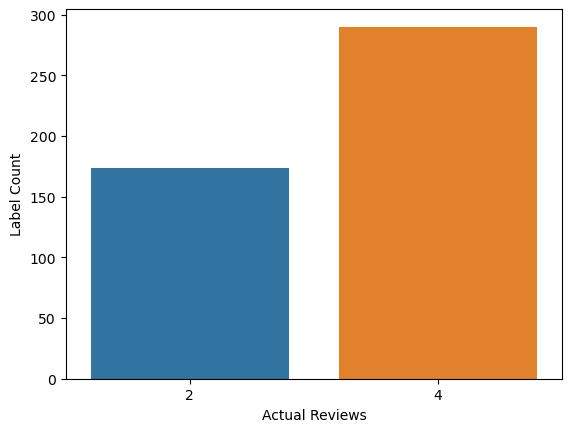

In [82]:
dev['pred'] = dev_pred_y
mislabeled = dev[dev['stars'] != dev['pred']]
mislabeled_count = mislabeled[['stars']].groupby('stars').value_counts()
mislabeled_dict = {
    'review': [],
    'count': []
}
for k, v in mislabeled_count.items():
    mislabeled_dict['review'].append(k)
    mislabeled_dict['count'].append(v)

sns.barplot(data=mislabeled_dict, x='review', y='count')
plt.xlabel('Actual Reviews')
plt.ylabel('Label Count')
for text, label, pred, doc_id in mislabeled[['text','stars','pred','doc_id']].values[:10]:
    print('Doc ID:', doc_id)
    print('Labeled as:', 'positive' if label == 4 else 'negative')
    print('Predicted as:', 'positive' if pred == 4 else 'negative')
    print('Text:',text, '\n')

Different from the previous algorithm most mislabels are germane to the negative sentiment. Unfortunately I thought the NN would've yielded better metrics than the SVM given its activation functions.

Looking at document z9zfIMYmRRCE4ggfOIieEw, it was mislabeled as negative rather than positive. The review is long and it uses double negation to state a positive sentiment. It's a good review, it's detailed, long, and it explains to the reader what to expect with verbiage such as "I don't mind waiting for my food..." and "For those that don't know curtido...". I think reviews such as this one tend to be mislabeled as negative given the amount of negative words in the corpus, along with the length and count of sentences.

Document Wi9nelif4zOl3Vux2tvyXw is an interesting one. It's short and it doesn't use words that stand out negatively. Maybe if we build a dictionary of foul words and check for those this one might be correctly labeled. Then again, if we pursue the route we could end up mislabeling a positive review as a bad review. 

Another review we can look at is PFmocUOXp92QWVDaFA where it does use negative words (not). It also uses the word ok. At the top of this notebook we saw a graph of the top 10 words for negative and positive reviews, containing ok only for negative reviews. For this and other words that are only seen in negative reviews we could weight those words by a small factor as to make the feature more important when training.

(d) Feature Engineering

Let's add the SentiWordNet sentiment classification and a bigram-tfid as features by expanding the FeatureEncoder class. For the bigram-tfid is wanted to trim the corpus by stemming the tokens for each text and removing stop words, words with frequencies less than 2, word of length less than 2, and punctuation. Unfortunately I could not implement it correctly.

In [257]:
# let's now add our own features
import math
import regex
import nltk
import pandas as pd
from collections import Counter
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
from nltk import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer


import logging
logger = logging.getLogger(__name__)
logging.basicConfig(encoding='utf-8', level=logging.DEBUG)

"""
Feature list:
"""
class FeatureEncoderEnhanced():
    def __init__(self):
        self.positive_words = pd.read_csv('https://ptrckprry.com/course/ssd/data/positive-words.txt', skiprows=33).values.flatten()
        self.negative_words = pd.read_csv('https://ptrckprry.com/course/ssd/data/negative-words.txt', skiprows=33, encoding='latin-1').values.flatten()
        self.words_to_count = ['food', 'place', 'good','one','well','pizza','eat','great','cheese','night','service','star','ok','restaurant',]
        self.pronouns = [
            'i',
            'you',
            'my',
            'mine',
            'myself'
            'we',
            'us',
            'our',
            'ours',
            'ourselves'
            'you',
            'you',
            'your',
            'yours',
            'yourself'
            'you',
            'you',
            'your',
            'your',
            'yourselves'
        ]
        self.stop_words = nltk.corpus.stopwords.words('english')
        self.vocabulary = []
        self.bow=None
        self.features=None
        self.vectorizer = TfidfVectorizer(analyzer='word', ngram_range=(1,2))
        self.tfid=None
        self.stemmer=SnowballStemmer('english')

    def fit(self, text: pd.DataFrame):
        """
        Create features
        """
        self.bow = None
        text['text'] = text['text'].apply(lambda t: t.lower())
        self.bow = self.create_bag_of_words(text)
        self.tfid = self.create_tfid(text=text)

    def transform(self, text: pd.DataFrame):
        features = pd.DataFrame()
        text['text'] = text['text'].apply(lambda t: t.lower())

        # count smiley
        logging.debug('[*] creating smiley_count')
        features['smiley_count'] = text['text'].apply(self.count_smiley_faces)
        # count hastags
        logging.debug('[*] creating hashtag_count')
        features['hastag_count'] = text['text'].apply(self.count_hashtags)
        # word count
        logging.debug('[*] creating word_count')
        features['word_count'] = text['text'].apply(self.log_count_words)
        #pronoun count
        logging.debug('[*] creating pronoun_count')
        features['pronoun_count'] = text['text'].apply(self.count_pronouns_in_text)
        #no in text count
        logging.debug('[*] creating no_count')
        features['no_count'] = text['text'].apply(self.count_no_in_text)
        # common word count
        logging.debug('[*] creating common_words_count')
        features['common_words_count'] = text['text'].apply(self.common_word_count)
        # punc count
        logging.debug('[*] creating punc_count')
        features['punc_count'] = text['text'].apply(self.count_punc)
        # positive word count
        logging.debug('[*] creating positive_word_count')
        features['positive_count'] = text['text'].apply(self.count_positive_words)
        # negative word count
        logging.debug('[*] creating negative_word_count')
        features['negative_count'] = text['text'].apply(self.count_negative_words)
        # double !! count
        logging.debug('[*] creating double_exclamation_count')
        features['double_exclamation_count'] = text['text'].apply(self.double_punctuation_count)
        # number list (1)) count
        logging.debug('[*] creating list_count')
        features['list_count'] = text['text'].apply(self.double_punctuation_count)
        # # create bag of words
        logging.debug('[*] creating bag of words')
        bag_of_word = self.populate_bag_of_words(text)

        # get sentiment from sentiwordnet
        logging.debug('[*] creating sentinet sentiment score')
        features['negative_sentinet_score'] = text['text'].apply(lambda t: self.get_sentiment(t, 'neg'))
        features['positive_sentinet_score'] = text['text'].apply(lambda t: self.get_sentiment(t, 'pos'))

        # create tfid
        # logging.debug('[*] creating TFID')
        # tfid = pd.DataFrame(self.create_tfid(text))

        columns = ['smiley_count', 'hastag_count', 'word_count', 'pronoun_count', 'no_count','common_words_count',
                   'punc_count','positive_count', 'negative_count','double_exclamation_count','list_count',
                   'negative_sentinet_score','positive_sentinet_score']
        # tfid_columns = ['tfid_f_' + str(i) for i in range(tfid.shape[1])]
        # columns.extend(tfid_columns)
        bow_columns = ['bow_f_' + str(i) for i in range(bag_of_word.shape[1])]
        columns.extend(bow_columns)

        features = pd.concat([features, bag_of_word], axis=1)
        features.columns = columns

        return features

    def fit_transform(self, text: pd.DataFrame):
        text['text'] = text['text'].apply(lambda t: t.lower())
        self.fit(text)
        return self.transform(text)
    
    def count_smiley_faces(self, text: str):
        if ':)' in text or ':-)' in text or ': )' in text:
            return 1
        return 0

    def count_hashtags(self, text: str):
        if '#' in text:
            return 1
        return 0

    def log_count_words(self, text: str):
        length = len([word for word in nltk.word_tokenize(text) if word.isalnum()])
        return math.log(length) if length != 0 else 0

    def count_pronouns_in_text(self, text: str):
        count = 0
        for word in nltk.word_tokenize(text):
            count += int(word.lower() in self.pronouns)
        return math.log(count) if count != 0 else 0

    def count_no_in_text(self, text: str):
        count = 0
        for word in nltk.word_tokenize(text):
            count += int('no' == word.lower())
        return math.log(count) if count != 0 else 0

    def common_word_count(self, text: str):
        count = 0
        for word in text:
            count += int(word.lower() in self.words_to_count)
        return math.log(count) if count != 0 else 0

    def count_punc(self,text):
        tokens = nltk.word_tokenize(text)
        punct_counts = Counter(token for token in tokens if not token.isalnum())
        sum_values = sum(punct_counts.values())
        return math.log(sum_values) if sum_values != 0 else 0

    def count_positive_words(self, text: str):
        count = 0
        for word in nltk.word_tokenize(text.lower()):
            count += int(word in self.positive_words)
        return math.log(count) if count != 0 else 0

    def count_negative_words(self, text: str):
        count = 0
        for word in nltk.word_tokenize(text.lower()):
            count += int(word in self.negative_words)
        return math.log(count) if count != 0 else 0

    def double_punctuation_count(self, text:str):
        return int('!!' in text)

    def number_list_count(self,text:str):
        """
        Check if review has itemized list, e.g. 1) 2) 3)...
        """
        pattern = regex.compile('/\d\)/gm')
        matched_1 = 1 if regex.search(pattern, text) is not None else 0
        pattern = regex.compile('/\d\./gm')
        matched_2 = 1 if regex.search(pattern, text) is not None else 0
        return any([matched_1 == 1, matched_2 == 1])

    def get_all_tokens(self, text: pd.DataFrame, tfidf=False):
        # remove stop words
        def remove_words(tokens):
            return [t for t in tokens if t not in self.stop_words]
        # stem words
        def stem_words(tokens):
            return [self.stemmer.stem(t) for t in tokens]
        def remove_punctuation_marks(tokens):
            return [t for t in tokens if t.isalnum()]
        def remove_words_len_2_or_less(tokens):
            return [t for t in tokens if len(t) > 2]
        tokens = []
        tokens_per_doc = []
        for t in text['text']:
            t_tokens = nltk.word_tokenize(t)
            t_tokens = remove_punctuation_marks(t_tokens)
            t_tokens = remove_words(t_tokens)
            t_tokens = remove_words_len_2_or_less(t_tokens)
            t_tokens = stem_words(t_tokens)
            tokens.extend(t_tokens)
            tokens_per_doc.append(t_tokens)

        # get frequency count
        freq_dist = nltk.FreqDist(tokens)
        # remove tokens that occur less than twice
        tokens = [token for token in tokens if freq_dist.get(token) > 2]
        temp = []
        for t_tokens in tokens_per_doc:
            t_tokens = [token for token in t_tokens if freq_dist.get(token) > 2]
            temp.append(t_tokens)
        
        return temp if tfidf else tokens
    

    def build_vocabulary(self, text: pd.DataFrame):
        return list(set(self.get_all_tokens(text)))

    def create_tfid(self, text: pd.DataFrame):
        # tokens = self.get_all_tokens(text, tfidf=True)
        return self.vectorizer.fit_transform(text['text']).toarray()

    def create_bag_of_words(self, text: pd.DataFrame):
        self.vocabulary = self.build_vocabulary(text)
        bow = []
        for i, row in text.iterrows():
            bag = [0]*len(self.vocabulary)
            t = row['text']
            for i,v in enumerate(self.vocabulary):
                if v in t:
                    bag[i] += 1
            bow.append(bag)
        return pd.DataFrame(bow)

    def populate_bag_of_words(self, text: pd.DataFrame):
        """Use existing vocabulary to fill bow"""
        bow = []
        for i, row in text.iterrows():
            bag = [0]*len(self.vocabulary)
            t = row['text']
            for i,v in enumerate(self.vocabulary):
                if v in t:
                    bag[i] += 1
            bow.append(bag)
        return pd.DataFrame(bow)

    def get_sentiment(self, sentence:str, sentiment:str):
        import nltk
        from nltk.corpus import wordnet as wn
        from nltk.corpus import sentiwordnet as swn
        tokenSentence = nltk.word_tokenize(sentence)
        posTagSentence = nltk.pos_tag(tokenSentence)

        sentimentPositive = 0.0
        sentimentNegatve = 0.0

        for wordTagPair in posTagSentence:
            word = wordTagPair[0]
            posTag = wordTagPair[1]

            if posTag.startswith('J'):
                posTag =  wn.ADJ
            elif posTag.startswith('R'):
                posTag =  wn.ADV    
            elif posTag.startswith('N'):
                posTag =  wn.NOUN
            else:
                continue
            
            wordSynst = wn.synsets(word, pos=posTag)
            if not wordSynst:
                continue  
            chosenSynst = wordSynst[0]
            sentiWordNet = swn.senti_synset(chosenSynst.name())

            sentimentPositive += sentiWordNet.pos_score() 
            sentimentNegatve +=  sentiWordNet.neg_score()

        if sentiment == 'pos':
            return sentimentPositive
        if sentiment == 'neg':
            return sentimentNegatve        
        
    

In [259]:
train = pd.read_csv('./train.tsv', delimiter='\t', header=None, encoding='iso-8859-1')
train.columns = ['stars', 'doc_id', 'text']

dev = pd.read_csv('./dev.tsv', delimiter='\t', header=None, encoding='iso-8859-1')
dev.columns = ['stars', 'doc_id', 'text']

fte = FeatureEncoderEnhanced()


fte.fit(train)
train_x = fte.transform(train)
train_y = train['stars'].values

dev_train_x = fte.transform(dev).values
dev_train_y = dev['stars'].values

DEBUG:root:[*] creating smiley_count
DEBUG:root:[*] creating hashtag_count
DEBUG:root:[*] creating word_count
DEBUG:root:[*] creating pronoun_count
DEBUG:root:[*] creating no_count
DEBUG:root:[*] creating common_words_count
DEBUG:root:[*] creating punc_count
DEBUG:root:[*] creating positive_word_count
DEBUG:root:[*] creating negative_word_count
DEBUG:root:[*] creating double_exclamation_count
DEBUG:root:[*] creating list_count
DEBUG:root:[*] creating bag of words
DEBUG:root:[*] creating sentinet sentiment score
DEBUG:root:[*] creating smiley_count
DEBUG:root:[*] creating hashtag_count
DEBUG:root:[*] creating word_count
DEBUG:root:[*] creating pronoun_count
DEBUG:root:[*] creating no_count
DEBUG:root:[*] creating common_words_count
DEBUG:root:[*] creating punc_count
DEBUG:root:[*] creating positive_word_count
DEBUG:root:[*] creating negative_word_count
DEBUG:root:[*] creating double_exclamation_count
DEBUG:root:[*] creating list_count
DEBUG:root:[*] creating bag of words
DEBUG:root:[*] 

<Axes: xlabel='pc1', ylabel='pc2'>

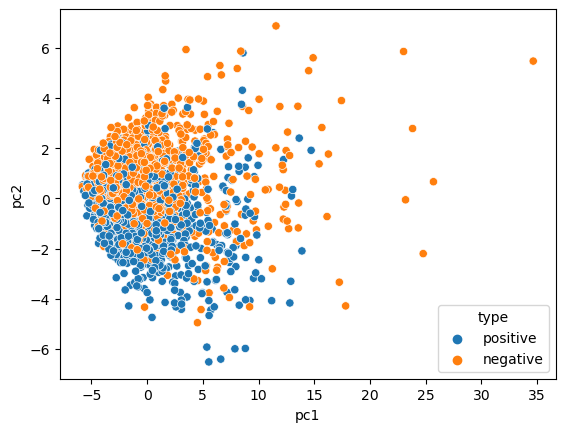

In [260]:
from sklearn.decomposition import PCA
import seaborn as sns

logging.basicConfig(encoding='utf-8', level=logging.exception)

pca = PCA(n_components=2)
components = pca.fit_transform(train_x) 
pca_view = {
    'pc1': components[:, 0],
    'pc2': components[:, 1],
    'type': ['positive' if y == 4 else 'negative' for y in train_y]
}
sns.scatterplot(data=pca_view, x='pc1',y='pc2',hue='type')

Text(0.5, 1.0, 'Features for record 1635 of sentiment NEGATIVE')

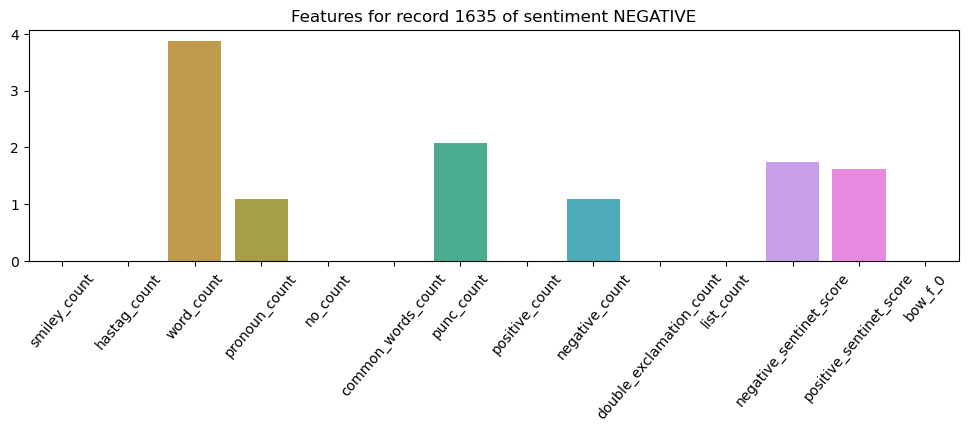

In [261]:
import numpy as np
RECORD=np.random.randint(low=0, high=train_x.shape[0])
# find first bag of word feature to slice by
bog_slice=list(train_x.columns).index('bow_f_1')
features={
    'features': train_x.iloc[RECORD, :bog_slice].keys(),
    'values': train_x.iloc[RECORD, :bog_slice].values
}
plt.figure(figsize=(12, 3))
sns.barplot(data=features, x='features', y='values')
plt.xticks(rotation=50)
plt.title(f'Features for record {RECORD} of sentiment {"POSITIVE" if train_y[RECORD] == 4 else "NEGATIVE"}')

In the plot above we can see the new features are present in for this record.

In [262]:
train_y = dev['stars'].values
# second classifier
from sklearn.svm import SVC

svm = SVC()
svm.fit(train_x, train_y)

dev_pred_y = svm.predict(dev_train_x)
true_positives, false_positives, true_negatives, false_negatives = calculate_confusion_matrix(dev_train_y, dev_pred_y)

precision_score = precision(true_positives, false_positives)
recall_score = recall(true_positives, false_negatives)
f1_score = f1_score_local(precision_score, recall_score)
print('Recall:', recall_score)
print('Precision:', precision_score)
print('F1 Score:', f1_score)

/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


Recall: 0.43075453677172876
Precision: 0.451
F1 Score: 0.4406448461162677


In the FeatureEncoderEnhanced I'm trying to build a bag-of-words representations from preprocessed text. The preprocessing tokenizes each sentence, prepends a NOT_ to every word after a token of logical negation, removes stop words, couple tokens to build an n-gram bag of words, and add the sentiment from SentiWordNet. After this step the intent is to build a vocabulary of unique terms. Based on the array of unique items I build a sparse array of size n where n is the number of unique terms in the vocabulary. I then iterate over each sentence and add 1 in the index the tokens are found in the vocabulary, thus creating a representation as [0, 0, ..., 0, 1]. 

Evidently, the attempt at creating a new bag of words representation did not meet expected results.

In [263]:
# predict on the test set
# encode features and run model
ft = FeatureEncoder()
train = pd.read_csv('./train.tsv', delimiter='\t', header=None, encoding='iso-8859-1')
train.columns = ['stars', 'doc_id', 'text']

test = pd.read_csv('./test.tsv', delimiter='\t', header=None, encoding='iso-8859-1')
test.columns = ['stars', 'doc_id', 'text']

dev = pd.read_csv('./dev.tsv', delimiter='\t', header=None, encoding='iso-8859-1')
dev.columns = ['stars', 'doc_id', 'text']


ft.fit(train)
train_x = ft.transform(train)
train_y = train['stars'].values

dev_train_x = ft.transform(dev).values
dev_train_y = dev['stars'].values

test_x = ft.transform(dev)
test_y = dev['stars'].values

# first classifier
from sklearn.svm import SVC

svm = SVC()
svm.fit(train_x, train_y)
dev_pred_y = svm.predict(test_x)


true_positives, false_positives, true_negatives, false_negatives = calculate_confusion_matrix(dev_train_y, dev_pred_y)
precision_score = precision(true_positives, false_positives)
recall_score = recall(true_positives, false_negatives)
f1_score = f1_score_local(precision_score, recall_score)
print('Recall:', recall_score)
print('Precision:', precision_score)
print('F1 Score:', f1_score)

DEBUG:root:[*] creating smiley_count
DEBUG:root:[*] creating hashtag_count
DEBUG:root:[*] creating word_count
DEBUG:root:[*] creating pronoun_count
DEBUG:root:[*] creating no_count
DEBUG:root:[*] creating common_words_count
DEBUG:root:[*] creating punc_count
DEBUG:root:[*] creating positive_word_count
DEBUG:root:[*] creating negative_word_count
DEBUG:root:[*] creating double_exclamation_count
DEBUG:root:[*] creating list_count
DEBUG:root:[*] creating bag of words
DEBUG:root:[*] creating smiley_count
DEBUG:root:[*] creating hashtag_count
DEBUG:root:[*] creating word_count
DEBUG:root:[*] creating pronoun_count
DEBUG:root:[*] creating no_count
DEBUG:root:[*] creating common_words_count
DEBUG:root:[*] creating punc_count
DEBUG:root:[*] creating positive_word_count
DEBUG:root:[*] creating negative_word_count
DEBUG:root:[*] creating double_exclamation_count
DEBUG:root:[*] creating list_count
DEBUG:root:[*] creating bag of words
DEBUG:root:[*] creating smiley_count
DEBUG:root:[*] creating has

Recall: 0.8431372549019608
Precision: 0.817
F1 Score: 0.8298628745556119


In [269]:
test_pred_y = svm.predict(test_x)

with open('adavila8.txt', 'w') as file:
    for pred, doc_id in zip(test_pred_y, test['doc_id'].values):
        file.write(f"{doc_id}\t{pred}\n")